# Density estimation with sparse transport maps

In this example we demonstrate how MParT can be use to build map with certain sparse structure in order to characterize high dimensional densities with conditional independence.

## Imports
First, import MParT and other packages used in this notebook. Note that it is possible to specify the number of threads used by MParT by setting the `KOKKOS_NUM_THREADS` environment variable **before** importing MParT.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm

import os
os.environ['KOKKOS_NUM_THREADS'] = '8'

import mpart as mt
print('Kokkos is using', mt.Concurrency(), 'threads')
plt.rcParams['figure.dpi'] = 110

Kokkos is usingKokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
  process threads available :   2,  requested thread :   8
 8 threads


Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
                                    Detected: 2 cores per node.
                                    Detected: 1 MPI_ranks per node.
                                    Requested: 8 threads per process.


## Stochastic volatility model

### Problem description

The problem considered here is a Markov process that describes the volatility on a financial asset overt time. The model depends on two hyperparamters $\mu$ and $\phi$ and state variable $Z_k$ represents log-volatility at times $k=1,...,T$. The log-volatility follows the order-one autoregressive process:
$$Z_{k+1} = \mu + \phi(Z_k-\mu) + \epsilon_k, k>1, $$
where
$$\mu \sim \mathcal{N}(0,1) $$
$$ \phi = 2\frac{\exp(\phi^*)}{1+\exp(\phi^*)}, \,\,\, \phi^* \sim \mathcal{N}(3,1)$$
$$ Z_0 | \mu, \phi \sim \mathcal{N}\left(\mu,\frac{1}{1-\phi^2}\right)$$

The objective is to characterize the joint density of
$$\mathbf{X}_T = (\mu,\phi,Z_1,...,Z_T), $$
with $T$ being arbitrarly large. 

The conditional independence property for this problem reads

$$ \pi(\mathbf{x}_t|\mathbf{x}_{<t}) = \pi(\mathbf{x}_t|\mathbf{x}_{t-1},\mu,\phi)$$

More details about this problem can be found in [[Baptista et al., 2022]](https://arxiv.org/pdf/2009.10303.pdf).

### Sampling



Drawing samples $(\mu^i,\phi^i,x_0^i,x_1^i,...,x_T^i)$ can be performed by the following function

In [2]:
def generate_SV_samples(d,N):
    # Sample hyper-parameters
    sigma = 0.25
    mu = np.random.randn(1,N)
    phis = 3+np.random.randn(1,N)
    phi = 2*np.exp(phis)/(1+np.exp(phis))-1
    X = np.vstack((mu,phi))
    if d > 2:
        # Sample Z0
        Z = np.sqrt(1/(1-phi**2))*np.random.randn(1,N) + mu

        # Sample auto-regressively
        for i in range(d-3):
            Zi = mu + phi * (Z[-1,:] - mu)+sigma*np.random.randn(1,N)
            Z = np.vstack((Z,Zi))

        X = np.vstack((X,Z))
    return X

Set dimension of the problem:

In [3]:
T = 30 #number of time steps including initial condition
d = T+2

Few realizations of the process look like

Text(0.5, 0, 'Days (d)')

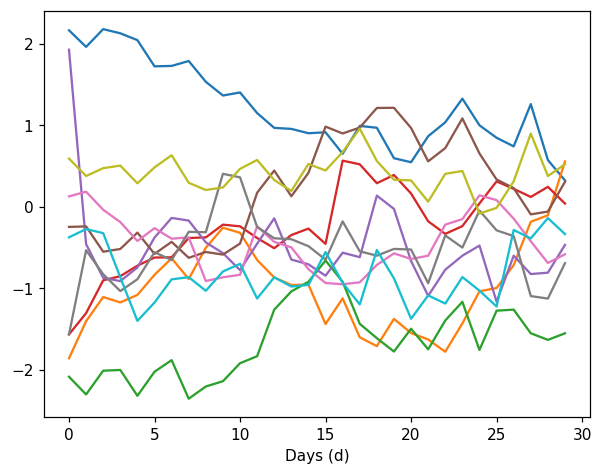

In [4]:
Nvisu = 10 #Number of samples
Xvisu = generate_SV_samples(d, Nvisu)

Zvisu = Xvisu[2:,:]

plt.figure()
plt.plot(Zvisu)
plt.xlabel("Days (d)")

And corresponding realization of hyperparameters

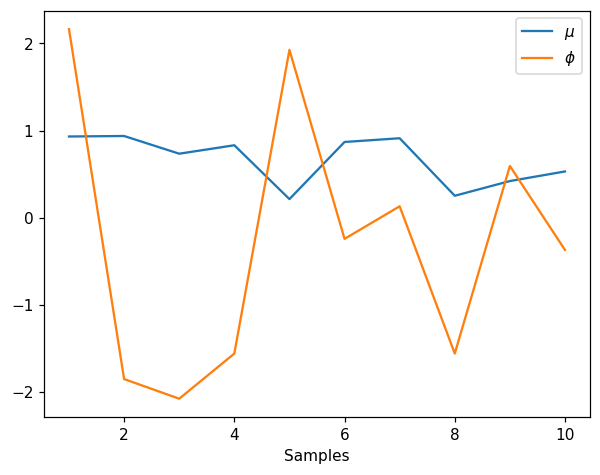

In [5]:
hyper_params = Xvisu[:2,:]
plt.figure()
plt.plot(range(1,Nvisu+1),Xvisu[1,:],label='$\mu$')
plt.plot(range(1,Nvisu+1),Xvisu[2,:],label='$\phi$')
plt.xlabel('Samples')
plt.legend()
plt.show()

### Probability density function


The exact log-conditional densities used to define joint density $\pi(\mathbf{x}_T)$ are defined by the following function:

In [6]:
def SV_log_pdf(X):
    
    def normpdf(x,mu,sigma):
        return  np.exp(-0.5 * ((x - mu)/sigma)**2) / (np.sqrt(2*np.pi) * sigma)
    
    sigma = 0.25

    # Extract variables mu, phi and states
    mu = X[0,:]
    phi = X[1,:]
    Z = X[2:,:]

    # Compute density for mu
    piMu = multivariate_normal(np.zeros(1),np.eye(1))
    logPdfMu = piMu.logpdf(mu)
    # Compute density for phi
    phiRef = np.log((1+phi)/(1-phi))
    dphiRef = 2/(1-phi**2)
    piPhi = multivariate_normal(3*np.ones(1),np.eye(1))
    logPdfPhi = piPhi.logpdf(phiRef)+np.log(dphiRef)
    # Add piMu, piPhi to density
    logPdf = np.vstack((logPdfMu,logPdfPhi))

    # Number of time steps
    dz = Z.shape[0]
    if dz > 0:
        # Conditonal density for Z_0
        muZ0 = mu
        stdZ0 = np.sqrt(1/(1-phi**2))
        logPdfZ0 = np.log(normpdf(Z[0,:],muZ0,stdZ0))
        logPdf = np.vstack((logPdf,logPdfZ0))

        # Compute auto-regressive conditional densities for Z_i|Z_{1:i-1}
        for i in range(1,dz):
            meanZi = mu + phi * (Z[i-1,:]-mu)
            stdZi = sigma
            logPdfZi = np.log(normpdf(Z[i,:],meanZi,stdZi))
            logPdf = np.vstack((logPdf,logPdfZi))
    return logPdf

## Transport map training

In the following we optimize each map component $S_k$, $k \in \{1,...,T+2\}$:

* For $k=1$, map $S_1$ characterize marginal density $\pi(\mu)$
* For $k=2$, map $S_2$ characterize conditional density $\pi(\phi|\mu)$
* For $k=3$, map $S_3$ characterize conditional density $\pi(z_0|\phi,\mu)$
* For $k>3$, map $S_k$ characterize conditional density $\pi(z_{k-2}|z_{k-3},\phi,\mu)$

Definition of log-conditional density from map component $S_k$

In [7]:
def log_cond_pullback_pdf(triMap,eta,x):
    r = triMap.Evaluate(x)
    log_pdf = eta.logpdf(r.T)+triMap.LogDeterminant(x)
    return log_pdf

### Generating training and testing samples

From training samples generated with the known function we compare accuracy of the transport map induced density using different parameterization and a limited number of training samples.

In [8]:
N = 2000 #Number of training samples
X = generate_SV_samples(d, N)

Ntest = 5000 # Number of testing samples
Xtest = generate_SV_samples(d,Ntest)

### Objective function and gradient

We use the minimization of negative log-likelihood to optimize map components.

For map component $k$, the objective function is given by 

$$
J_k(\mathbf{w}_k) = - \frac{1}{N}\sum_{i=1}^N \left( \log\eta\left(S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) + \log \frac{\partial S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k}\right)
$$

and corresponding gradient
$$
\nabla_{\mathbf{w}_k}J_k(\mathbf{w}_k) = - \frac{1}{N}\sum_{i=1}^N \left(\left[\nabla_{\mathbf{w}_k}S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right]^T \nabla_\mathbf{r}\log \eta \left(S_k
(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) - \frac{\partial \nabla_{\mathbf{w}_k}S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k} \left[\frac{\partial S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k}\right]^{-1}\right),
$$

In [9]:
### Negative log likelihood objective
def obj(coeffs, tri_map,x):
    """ Evaluates the log-likelihood of the samples using the map-induced density. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Compute the map-induced density at each point 
    map_of_x = tri_map.Evaluate(x)

    rho = multivariate_normal(np.zeros(tri_map.outputDim),np.eye(tri_map.outputDim))
    rho_of_map_of_x = rho.logpdf(map_of_x.T)
    log_det = tri_map.LogDeterminant(x)

    # Return the negative log-likelihood of the entire dataset
    return -np.sum(rho_of_map_of_x + log_det)/num_points

def grad_obj(coeffs, tri_map, x):
    """ Returns the gradient of the log-likelihood objective wrt the map parameters. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Evaluate the map
    map_of_x = tri_map.Evaluate(x)

    # Now compute the inner product of the map jacobian (\nabla_w S) and the gradient (which is just -S(x) here)
    grad_rho_of_map_of_x = -tri_map.CoeffGrad(x, map_of_x)

    # Get the gradient of the log determinant with respect to the map coefficients
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points

### Training total order 1 map

Here we use a total order 1 multivariate expansion to parameterize each component $S_k$, $k \in \{1,...,T+2\}$.

In [10]:
opts = mt.MapOptions()
opts.basisType = mt.BasisTypes.HermiteFunctions 

#### Optimization

In [11]:
# Total order 1 approximation
totalOrder = 1
logPdfTM_to1 = np.zeros((d,Ntest))
ListCoeffs_to1=np.zeros((d,))
for dk in tqdm(range(1,d+1),desc="Map component"):
    fixed_mset= mt.FixedMultiIndexSet(dk,totalOrder)
    S = mt.CreateComponent(fixed_mset,opts)
    Xtrain = X[:dk,:]
    Xtestk = Xtest[:dk,:]

    ListCoeffs_to1[dk-1]=S.numCoeffs

    options={'gtol': 1e-3, 'disp': False}
    res = minimize(obj, S.CoeffMap(), args=(S, Xtrain), jac=grad_obj, method='BFGS', options=options)
    
    # Reference density
    eta = multivariate_normal(np.zeros(S.outputDim),np.eye(S.outputDim))

    # Compute log-conditional density at testing samples
    logPdfTM_to1[dk-1,:]=log_cond_pullback_pdf(S,eta,Xtestk)


Map component: 100%|██████████| 32/32 [00:04<00:00,  7.84it/s]


#### Compute KL divergence error

Since we know what the true is for problem we can compute the KL divergence $D_{KL}(\pi(\mathbf{x}_t)||S^\sharp \eta)$ between the map-induced density and the true density.

In [12]:
logPdfSV = SV_log_pdf(Xtest) # true log-pdf

def compute_joint_KL(logPdfSV,logPdfTM):
    KL = np.zeros((logPdfSV.shape[0],))
    for k in range(1,d+1):
        KL[k-1]=np.mean(np.sum(logPdfSV[:k,:],0)-np.sum(logPdfTM[:k,:],0))
    return KL

# Compute joint KL divergence for total order 1 approximation
KL_to1 = compute_joint_KL(logPdfSV,logPdfTM_to1)

### Training total order 2 map

Here we use a total order 2 multivariate expansion to parameterize each component $S_k$, $k \in \{1,...,T+2\}$.

#### Optimization

This step can take few minutes depending on the number of time steps set at the definition of the problem.

In [13]:
# Total order 2 approximation
totalOrder = 2
logPdfTM_to2 = np.zeros((d,Ntest))
ListCoeffs_to2=np.zeros((d,))
for dk in tqdm(range(1,d+1),desc="Map component"):
    fixed_mset= mt.FixedMultiIndexSet(dk,totalOrder)
    S = mt.CreateComponent(fixed_mset,opts)
    Xtrain = X[:dk,:]
    Xtestk = Xtest[:dk,:]

    ListCoeffs_to2[dk-1]=S.numCoeffs

    options={'gtol': 1e-3, 'disp': False}
    res = minimize(obj, S.CoeffMap(), args=(S, Xtrain), jac=grad_obj, method='BFGS', options=options)
    
    # Reference density
    eta = multivariate_normal(np.zeros(S.outputDim),np.eye(S.outputDim))

    # Compute log-conditional density at testing samples
    logPdfTM_to2[dk-1,:]=log_cond_pullback_pdf(S,eta,Xtestk)


Map component: 100%|██████████| 32/32 [10:54<00:00, 20.46s/it]


#### Compute KL divergence error

In [14]:
# Compute joint KL divergence for total order 2 approximation
KL_to2 = compute_joint_KL(logPdfSV,logPdfTM_to2)

### Training sparse map

Here we use the prior knowledge of the conditional independence property of the target density $\pi(\mathbf{x}_T)$ to parameterize map components with a map structure.

#### Prior knowledge used to parameterize map components

From the independence structure mentionned in the problem formulation we have:


*   $\pi(\mu,\phi)=\pi(\mu)\pi(\phi)$, meaning $S_2$ only dependes on $\phi$
*   $\pi(z_{k-2}|z_{k-3},...,z_{0},\phi,\mu)=\pi(z_{k-2}|z_{k-3},\phi,\mu),\,\, k>3$,  meaning $S_k$, only depends on $z_{k-2}$,$z_{k-3}$, $\phi$ and $\mu$



Complexity of map component can also be deducted from problem formulation:


*   $\pi(\mu)$ being a normal distribution, $S_1$ should be of order 1.
*  $\pi(\phi)$ is non-Gaussian such that $S_2$ should be nonlinear.
*  $\pi(z_{k-2}|z_{k-3},\phi,\mu)$ can be represented by a total order 2 parameterization due to the linear autoregressive model.




Hence multi-index sets used for this problem are:


*   $k=1$: 1D expansion of order $\geq$ 1
*   $k=2$: 1D expansion (depending on last component) of high order $>1$
*   $k=3$: 3D expansion of total order 2
*   $k>3$: 4D expansion (depending on first two and last two components) of total order 2



#### Optimization

In [15]:
totalOrder = 2
logPdfTM_sa = np.zeros((d,Ntest))
ListCoeffs_sa = np.zeros((d,))

# MultiIndexSet for map S_k, k>3
mset_to= mt.MultiIndexSet.CreateTotalOrder(4,totalOrder,mt.NoneLim()) 

maxOrder=9 # order for map S_2
for dk in tqdm(range(1,d+1),desc="Map component"):
    if dk == 1:
        fixed_mset= mt.FixedMultiIndexSet(1,totalOrder)
        S = mt.CreateComponent(fixed_mset,opts)
        Xtrain = X[dk-1,:].reshape(1,-1)
        Xtestk = Xtest[dk-1,:].reshape(1,-1)
    elif dk == 2:
        fixed_mset= mt.FixedMultiIndexSet(1,maxOrder)
        S = mt.CreateComponent(fixed_mset,opts)
        Xtrain = X[dk-1,:].reshape(1,-1)
        Xtestk = Xtest[dk-1,:].reshape(1,-1) 
    elif dk==3:
        fixed_mset= mt.FixedMultiIndexSet(dk,totalOrder)
        S = mt.CreateComponent(fixed_mset,opts)
        Xtrain = X[:dk,:]
        Xtestk = Xtest[:dk,:]
    else:
        multis=np.zeros((mset_to.Size(),dk))
        for s in range(mset_to.Size()):
            multis_to = np.array([mset_to[s].tolist()])
            multis[s,:2]=multis_to[0,:2]
            multis[s,-2:]=multis_to[0,-2:]
        mset = mt.MultiIndexSet(multis)
        fixed_mset = mset.fix(True)
        S = mt.CreateComponent(fixed_mset,opts)
        Xtrain = X[:dk,:]
        Xtestk = Xtest[:dk,:]

    ListCoeffs_sa[dk-1]=S.numCoeffs

    options={'gtol': 1e-3, 'disp': False}
    res = minimize(obj, S.CoeffMap(), args=(S, Xtrain), jac=grad_obj, method='BFGS', options=options)
    rho = multivariate_normal(np.zeros(S.outputDim),np.eye(S.outputDim))    
    
    logPdfTM_sa[dk-1,:]=log_cond_pullback_pdf(S,rho,Xtestk)

Map component: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


#### Compute KL divergence error

In [16]:
# Compute joint KL divergence
KL_sa = compute_joint_KL(logPdfSV,logPdfTM_sa)

## Compare approximations

### KL divergence

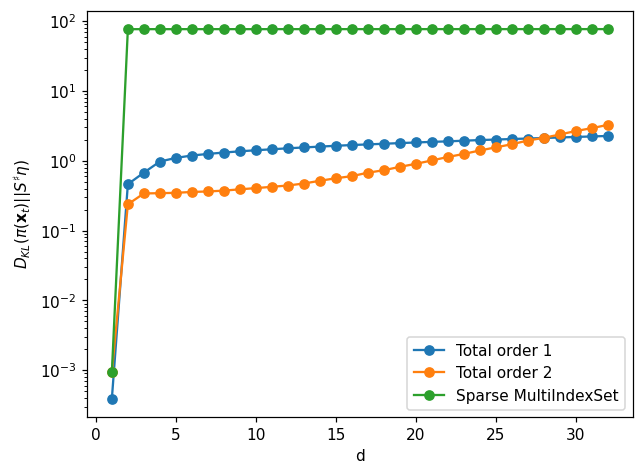

In [17]:
# Compare map approximations 
fig, ax = plt.subplots()
ax.plot(range(1,d+1),KL_to1,'-o',label='Total order 1')
ax.plot(range(1,d+1),KL_to2,'-o',label='Total order 2')
ax.plot(range(1,d+1),KL_sa,'-o',label='Sparse MultiIndexSet')
ax.set_yscale('log')
ax.set_xlabel('d')
ax.set_ylabel('$D_{KL}(\pi(\mathbf{x}_t)||S^\sharp \eta)$')
plt.legend()
plt.show()

Usually increasing map complexity will improve map approximation. However when the number of parameters increases too much compared to the number of samples, computed map overfits the data which lead to worst approximation. This overfitting can be seen in this examples when looking at the total order 2 approximation that rapidly loses accuracy when the dimension increases.

Using sparse multi-index sets help reduces the increase of parameters when the dimension increases leading to better approximation for all dimensions.

### Map coefficients

To complement observations made above, we visualize the number of parameters (polyniomal coefficients) for each map parameterization.

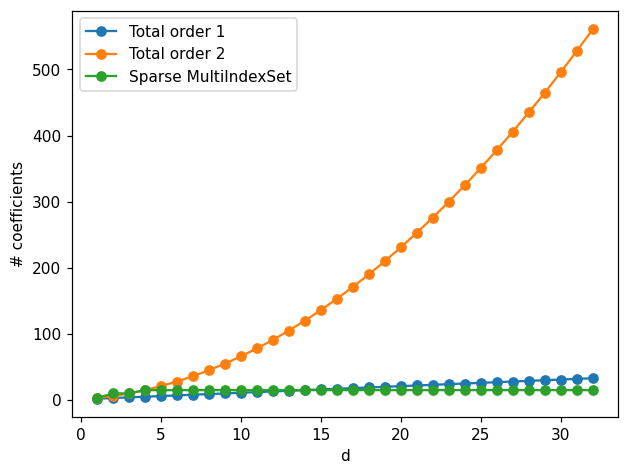

In [18]:
fig, ax =plt.subplots()
ax.plot(range(1,d+1),ListCoeffs_to1,'-o',label='Total order 1')
ax.plot(range(1,d+1),ListCoeffs_to2,'-o',label='Total order 2')
ax.plot(range(1,d+1),ListCoeffs_sa,'-o',label='Sparse MultiIndexSet')
ax.set_xlabel('d')
ax.set_ylabel('# coefficients')
plt.legend()
plt.show()

We can observe the exponential growth of the number coefficients for the total order 2 approximation. Chosen sparse multi-index sets have a fixed number of parameters which become smaller than the number of parameters of the total order 1 approximation when dimension is 15.

Using less parameters helps error scaling with dimension but aslo helps reducing computation time for the optimization and the evaluation the transport maps.